# Bengali Handwritten Digit Recognizer 

This is a model based on Convolutional Neural Network (CNN) to recognize bengali handwritten digits. The digit recognizer is built in three steps, <br><br>
Step 1 : Process the data.<br>
Step 2 : Design the model.<br>
Step 3 : Train the model.

In [1]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from __future__ import print_function
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


## Step 1: Process the data

In [2]:
# Constants
FIG_WIDTH = 20 
HEIGHT_PER_ROW = 3 
IMAGE_RESIZE_DIM = 28 

In [3]:
# Define dataset path

data_dir='C:\\Bengali handwritten digit competition\\trainings & tests'

paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

### Image Processing 

Some helper functions are written to process and visualize the images. Color images are converted to gray scale image. 

For better understanding, images are unblurred and laplacian filter is used to make images sharper. 

To get better performance, rotated images are aligned and all images are zoomed upto bounding rectangle.

In [11]:
def get_key(path):
    key=path.split(sep=os.sep)[-1]
    return key


def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,0) 
        rows, cols = img.shape
        
        #checking whether binary image
        hist1 = cv2.calcHist([img],[0],None, [1], [0,1])
        hist2 = cv2.calcHist([img],[0],None, [1], [255,256])
        if (hist1 + hist2) == img.shape[0] * img.shape[1]:
            binary = True
        else:
            binary = False
        
        if binary == False:
            img = cv2.GaussianBlur(img, (5,5), 5.0) #unblur
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) 
            img = cv2.filter2D(img, -1, kernel)
            
            # Find corners of rotated image. Align horizontally. 
            ret, imgtemp = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            image, contours, hierarchy = cv2.findContours(imgtemp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnt = next((cn for cn in contours if cv2.contourArea(cn) > 0.3 * rows* cols), contours[0])
            
            leftmost = cnt[cnt[:,:,0].argmin()][0].tolist()
            rightmost = cnt[cnt[:,:,0].argmax()][0].tolist()
            topmost = cnt[cnt[:,:,1].argmin()][0].tolist()
            bottommost = cnt[cnt[:,:,1].argmax()][0].tolist()
            
            if (leftmost[1] > 4 and leftmost[1] < (rows - 4)) and (rightmost[1] > 4 or rightmost[1] < (rows - 4)):
                if(leftmost[1] >= topmost[0]): 
                    rot = "clockwise"
                    pts1 = np.float32([topmost, rightmost, bottommost, leftmost])
                else: 
                    rot = "anti-clockwise"
                    pts1 = np.float32([leftmost, topmost, rightmost, bottommost])
                pts2 = np.float32([[0,0], [cols, 0], [rows, cols], [0, rows]])
                M = cv2.getPerspectiveTransform(pts1, pts2)
                img = cv2.warpPerspective(img, M, (rows, cols))

            thresh = 200
            maxValue = 255
            ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        
        # Find bounding rectangle of digit
        image, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if(len(contours) == 0): contours.append(np.array([[0,0]], np.int32))
        
        cnt = max(contours, key = lambda x: x.size)
        
        padr = int(rows / 40)
        padc = int(cols / 40)
        x, y, w, h = cv2. boundingRect(cnt)
        pts1 = np.float32([[x, y], [x+w, y], [x, y+h]])
        pts2 = np.float32([[padc,padr], [cols-padc, padr], [padc, rows-padr]])
        M = cv2.getAffineTransform(pts1, pts2)
        img = cv2.warpAffine(img, M, (cols, rows))
        
        ret,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
        
        if(padc < padr): padc = padr
        img = cv2.rectangle(img,(0,0),(rows,cols),255,padc)
        
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
        
        
        X.append(img) 
        
        # Display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    
    X = np.array(X) 
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) 
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] 
        y=to_categorical(y_label,10) 
        return X, y
        
def imshow_group(X,y=None,name=None,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities. 
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: 'processed' or 'prediction'
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if phase=='processed':
            if y is not None and name is not None:
                plt.title(np.argmax(y[i]) + name[i])
            elif y is not None:
                plt.title(np.argmax(y[i]))
            elif name is not None:
                plt.title(name[i])
        if phase=='prediction':
            top_n=3 
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [6]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28), (72045, 10))

In [8]:
X_show_all=X_train_all

Let's see some samples of the processed data.

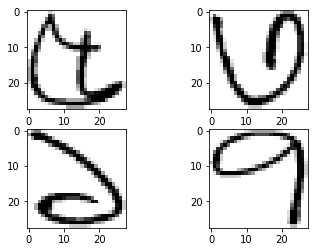

In [9]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
plt.show()

Histogram of digit

In [ ]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])
plt.show()

In [10]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)


processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


View samples from test dataset

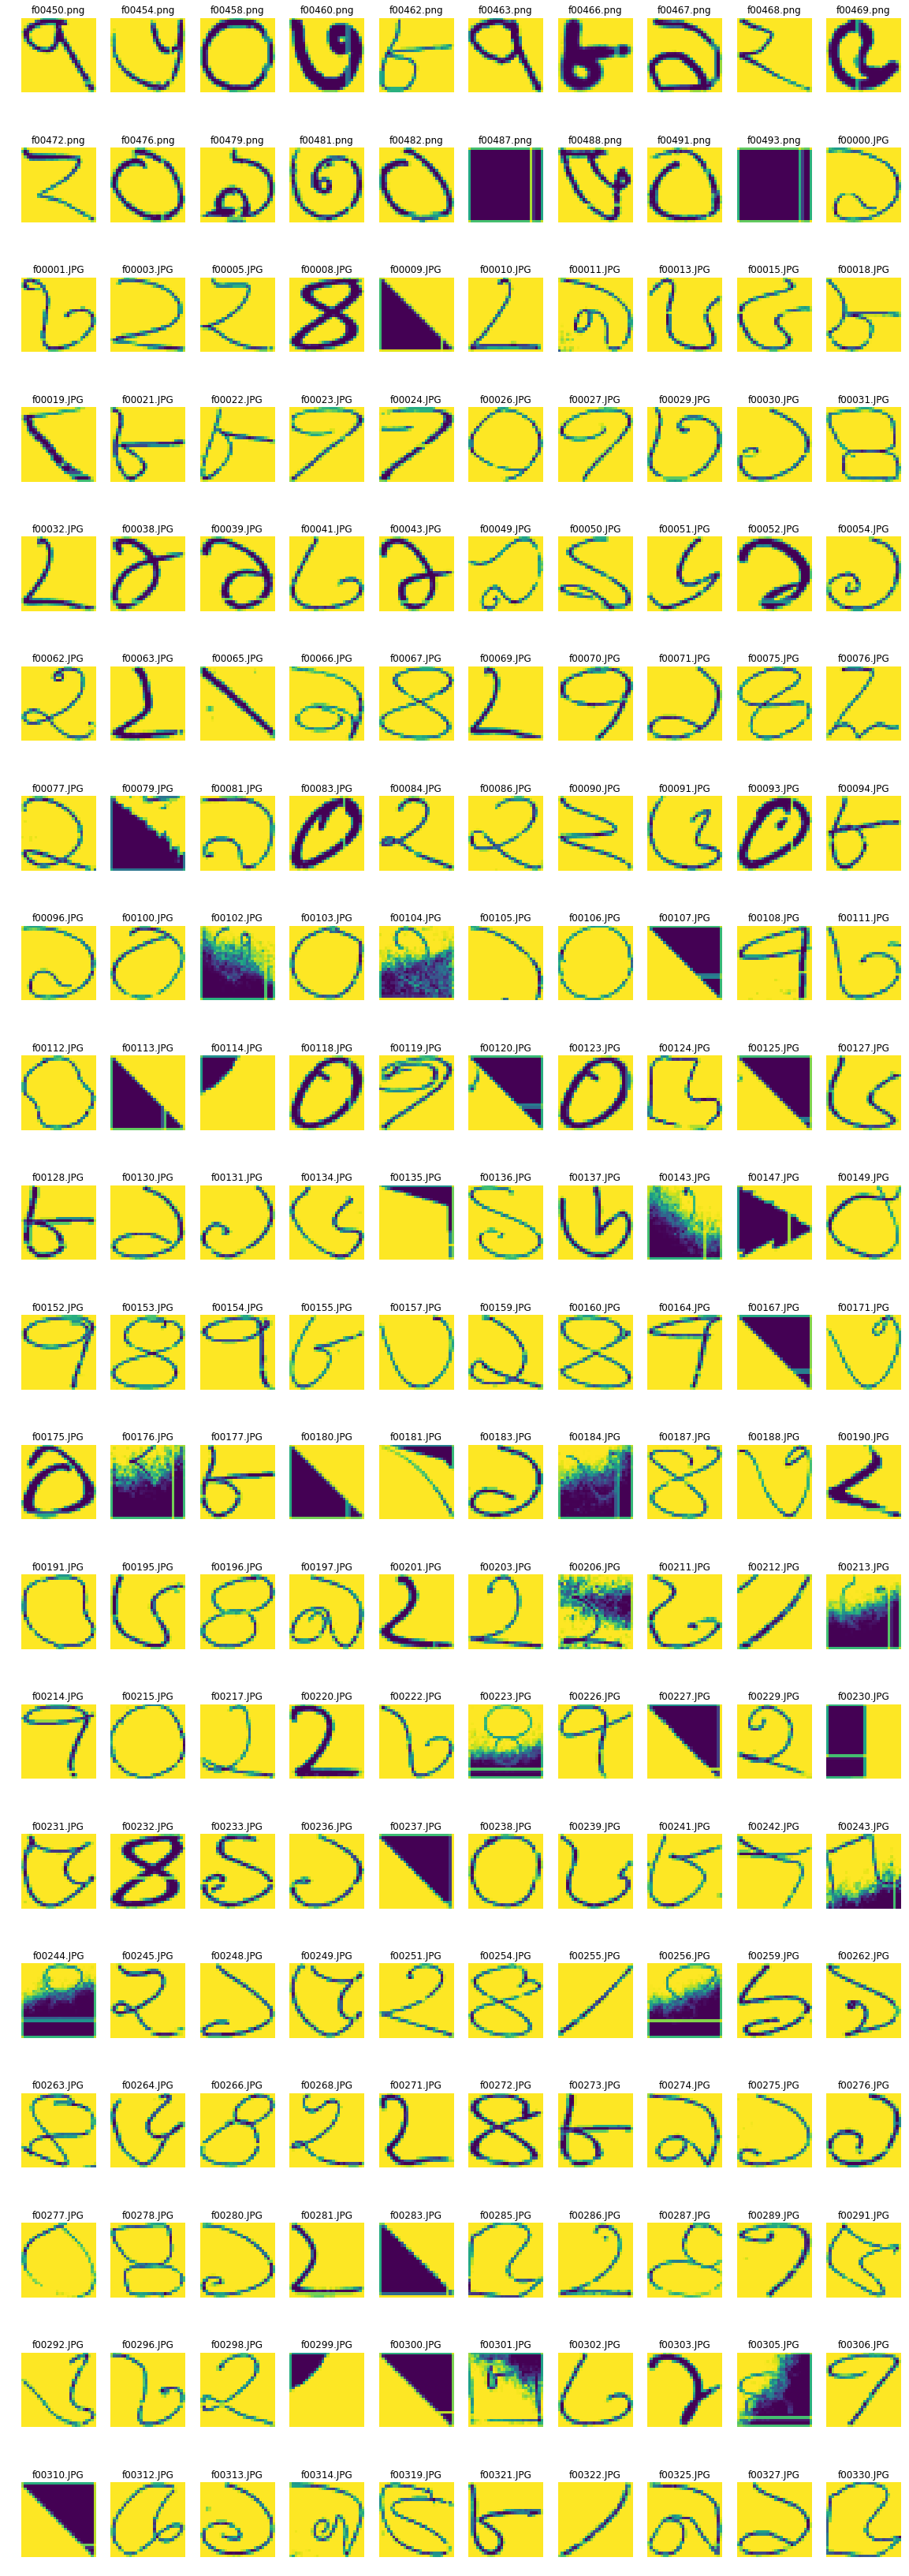

In [19]:
X_test_a=get_data(paths_test_f,path_label=None,resize_dim=RESIZE_DIM)
n_sample=200
ind = [i for i in range(200, 400)]
paths=[]
for i in ind:
    paths.append(paths_test_f[i])
keys=[get_key(path) for path in paths]
imshow_group(X=X_test_a[ind], name=keys)

In [11]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [12]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 28, 28)

Now convert image to 1 color channel

In [13]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],28, 28,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],28, 28,1).astype('float32')

In [14]:
X_train_all.shape

(72045, 28, 28, 1)

Normalize data

In [15]:
X_train_all = X_train_all/255

Training-validation split: 80%-20% 

In [16]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

## Step 2: Design the model

In [17]:
def my_model(img_size=28,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)

    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
    
model=my_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

## Step 3: Train the model

In [18]:
path_model='C:\\Bengali handwritten digit competition\\notebooks\\mymodel_filter.h5' 

K.tensorflow_backend.clear_session() 
model=my_model() 
K.set_value(model.optimizer.lr,6e-4)

h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=60,
            epochs=25,
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 57636 samples, validate on 14409 samples
Epoch 1/25
57636/57636 [==============================] - 636s 11ms/step - loss: 0.3028 - acc: 0.9038 - val_loss: 0.1037 - val_acc: 0.9711
Epoch 2/25
57636/57636 [==============================] - 705s 12ms/step - loss: 0.0981 - acc: 0.9726 - val_loss: 0.0747 - val_acc: 0.9793
Epoch 3/25
57636/57636 [==============================] - 722s 13ms/step - loss: 0.0731 - acc: 0.9793 - val_loss: 0.0684 - val_acc: 0.9820
Epoch 4/25
57636/57636 [==============================] - 709s 12ms/step - loss: 0.0597 - acc: 0.9833 - val_loss: 0.0657 - val_acc: 0.9829
Epoch 5/25
57636/57636 [==============================] - 745s 13ms/step - loss: 0.0512 - acc: 0.9853 - val_loss: 0.0610 - val_acc: 0.9844
Epoch 6/25
57636/57636 [==============================] - 687s 12ms/step - loss: 0.0439 - acc: 0.9875 - val_loss: 0.0548 - val_acc: 0.9854
Epoch 7/25
57636/57636 [==============================] - 752s 13ms/step - loss: 0.0382 - acc: 0.9888 - val_loss: 0.

In [8]:
path_model='C:\\Bengali handwritten digit competition\\notebooks\\mymodel_filter.h5'
model = load_model(path_model)

## Result Analysis

Let's observe the images by our model.

In [19]:
predictions_prob=model.predict(X_test_all) 

In [20]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

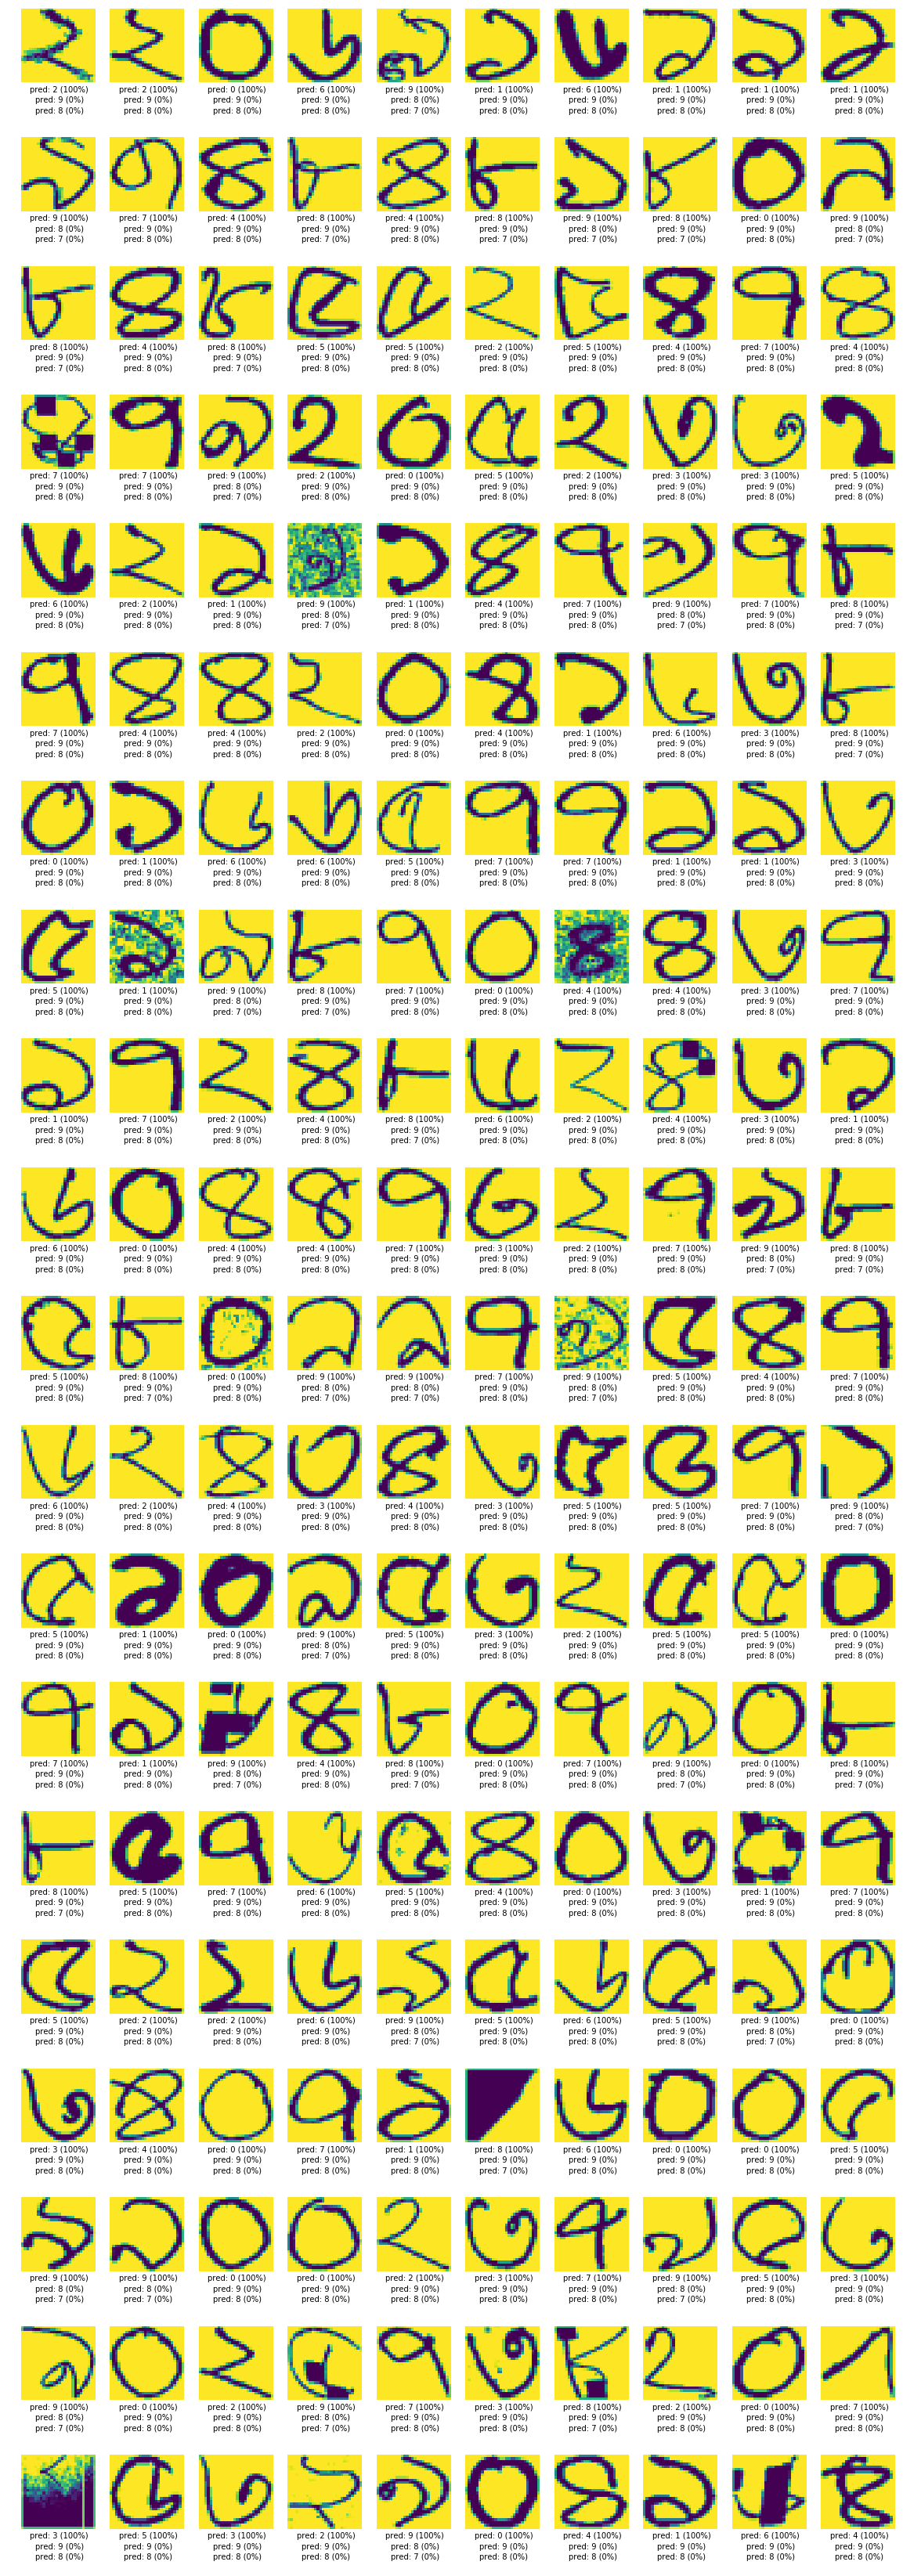

In [21]:

imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

In [22]:
labels=[np.argmax(pred) for pred in predictions_prob]
keys=[get_key(path) for path in paths_test_all ]
create_submission(predictions=labels,keys=keys,path='submission.csv')